<a href="https://colab.research.google.com/github/Shlokatadistance/Tech-/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install alphavantage


  Created wheel for foil: filename=foil-0.2.7-py36, py35-none-any.whl size=17258 sha256=3004be6874b7714295698c26505dd3a19794b6aed27f58313cea34406ca36f58
  Stored in directory: /root/.cache/pip/wheels/f7/51/12/847c3ca1a496ed87a7d663ecd78e7c7d2c97a4c32b1d6f6640
Successfully built foil


In [7]:
import pandas as pd
import requests

In [15]:
ticker = 'USDEUR'
key = '0D6HAHFDZPJLAL0E'
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey='+key
urlData = requests.get(url).json()['Time Series (Daily)']
Price_df = pd.DataFrame(urlData).T
Price_df = Price_df.drop(columns=['5. adjusted close' , '7. dividend amount', '8. split coefficient'])
Price_df = Price_df.astype(float)
Price_df = Price_df.iloc[::-1]
Price_df.reset_index(inplace=True)
Price_df.columns = ['Date', 'Open', 'High', 'Low', 'Close','Volume']
Price_df['Date'] = pd.to_datetime(Price_df['Date'])
Price_df
Price_df.to_csv('/content/data/fx.csv', encoding='utf-8', index=False)


In [16]:
import os
import json
import time
import math
import matplotlib.pyplot as plt
from data_processor import DataLoader
from model import Model



In [17]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


In [18]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [19]:
def accuracy_value(predicted_data,test_data):
    updown_prediction = pd.DataFrame({"Predicted":predicted_data.reshape(1,len(test_data))[0]})
    print(updown_prediction)

    updown_actual = pd.DataFrame({"Actual":test_data.reshape(1,len(test_data))[0]})
    print(updown_actual)

    results = []

    for i in range(0, len(dataset_test)-1):
        predicted_change = (updown_prediction['Predicted'][i+1] / updown_actual['Actual'][i]) - 1.0
        actual_change = (updown_actual['Actual'][i+1] / updown_actual['Actual'][i]) - 1.0

        if np.sign(predicted_change) == np.sign(actual_change):
            results.append(True)
        else:
            results.append(False)

    results.count(True)
    results.count(False)

    print(results)
    print('accuracy: ' + str(results.count(True)/len(results)))


[Model] Model Compiled
Time taken: 0:00:00.824106
[Model] Training Started
[Model] 2 epochs, 32 batch size, 48 batches per epoch


/content/model.py:83: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  workers=1


Epoch 1/2
48/48 [==============================] - 12s 132ms/step - loss: 0.0431
Epoch 2/2
48/48 [==============================] - 6s 127ms/step - loss: 0.0047
[Model] Training Completed. Model saved as saved_models/19112021-043641-e2.h5
Time taken: 0:00:18.227998
[Model] Predicting Point-by-Point...
[0.8226284  0.822322   0.8220614  0.82188535 0.8217821  0.82175845
 0.82181203 0.82196844 0.82222366 0.822539   0.8228961  0.82324994
 0.8235734  0.82386345 0.82411295 0.8243417  0.8245549  0.82474756
 0.8249513  0.82518494 0.82545596 0.8257941  0.8261657  0.826545
 0.8268815  0.8271534  0.8273469  0.82746905 0.82752645 0.8275395
 0.8275509  0.8275597  0.82755506 0.8275153  0.8274375  0.8273171
 0.82715446 0.82700205 0.8268976  0.8268369  0.82682616 0.82690156
 0.82709855 0.82745004 0.82792604 0.8284791  0.8290451  0.82960016
 0.8301374  0.8306616  0.8311351  0.83157027 0.8319773  0.8323463
 0.83271044 0.8331003  0.83354366 0.8340346  0.83457124 0.8351631
 0.8357988  0.8364365  0.8370547 

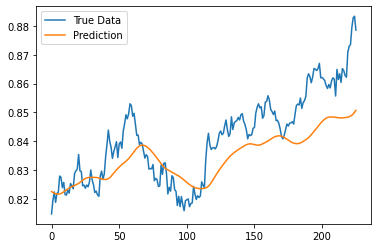

In [22]:
def main():
    configs = json.load(open('config.json', 'r'))
    if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

    data = DataLoader(
        os.path.join('data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
	# in-memory training
	model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
	)
	'''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )

    x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    #predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
    predictions = model.predict_point_by_point(x_test)
    print(predictions)
    # predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
    # predictions = model.predict_point_by_point(x_test)

    #plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
    plot_results(predictions,y_test)
    #print(type(x_test),type(predictions))
    #print(predictions.shape,x_test.shape)
    # plot_results(predictions, y_test)


if __name__ == '__main__':
    main()